2023-05-06 16:10:11.819395: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_72/moving_mean/Assign' id:2645 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_72/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_72/moving_mean, batch_normalization_72/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 16:10:12.963397: W tensorflow/c/c_api.cc:300] Operation '{name:'decay/Assign' id:5181 op device:{requested: '', assigned: ''} def:{{{node decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](decay, decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutatio

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


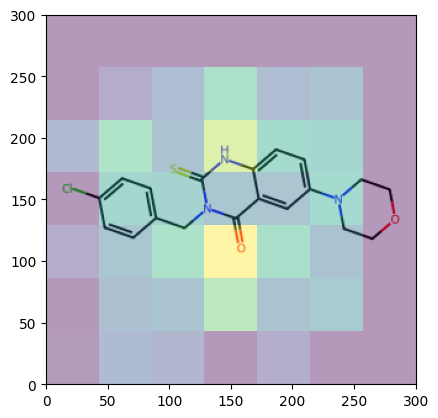

O=c1c2cc(N3CCOCC3)ccc2[nH]c(=S)n1Cc1ccc(Cl)cc1
(1, 80, 80, 3)


/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-06 16:10:43.882872: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1/Sigmoid' id:3584 op device:{requested: '', assigned: ''} def:{{{node dense_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [17]:
from keras.models import load_model
import keras.backend as K
import tensorflow as tf
# disable eager execution
tf.compat.v1.disable_eager_execution()

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from chemception.checmception_featurizer import ChemCeptionizer

from gradio import Interface

import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    session = tf.compat.v1.Session()
    K.set_session(session)
    
    model = load_model('chemception_transfer.h5')
    featurizer = ChemCeptionizer(embed=20, fuse=True)


    def plot_kernels(x):
        flower_output = model.output[:, 0]
        last_conv_layer = model.get_layer('mixed2')

        with graph.as_default():
            K.set_session(session)
            grads = K.gradients(flower_output, last_conv_layer.output)[0]                             
            pooled_grads = K.mean(grads, axis=(0, 1, 2))                                              
            iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
            pooled_grads_value, conv_layer_output_value = iterate([x])

        for i in range(288):                                                                     
                conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)                                                  
        heatmap /= np.max(heatmap)
        
        return heatmap


    def predict_smiles(smiles):
        print(smiles)
        mol = Chem.MolFromSmiles(smiles)
        mol_chemceptionized = featurizer.featurize(mol)
        mol_chemceptionized = np.expand_dims(mol_chemceptionized, axis=0)
        print(mol_chemceptionized.shape)
        
        with graph.as_default():
            K.set_session(session)
            prediction = model.predict(mol_chemceptionized)
            
        heatmap = plot_kernels(mol_chemceptionized)
        
        img = Draw.MolToImage(mol, size=(300, 300))
        extent = 0, 300, 0, 300
        fig, ax = plt.subplots(frameon=False)

        ax.imshow(img, extent=extent)
        ax.imshow(heatmap, cmap='viridis', alpha=0.4, extent=extent)

        return 'Active' if prediction[0][0] > 0.5 else 'Inactive', fig


    iface = Interface(
        fn=predict_smiles,
        inputs="text",
        outputs=["text", "plot"],
        examples=['O=c1c2cc(N3CCOCC3)ccc2[nH]c(=S)n1Cc1ccc(Cl)cc1']
    )
    
    iface.launch()